In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.datasets as datasets
import os
%matplotlib inline

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.act_hid = nn.ReLU()
        self.fc1 = nn.Linear(64*int(l/2-1)*int(l/2-1), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.act_hid(x)
        x = x.view(-1, 64*int(l/2-1)*int(l/2-1))
        x = self.fc1(x)
        x = self.act_hid(x)
        x = self.fc2(x)
        return x

In [19]:
def load_data(Jd, l, num_conf, T, num_temps, batch_size, shuffle_opt, opt='train'):
    datasets = []
    for j in range(num_temps):

        with open(f'data_spins/{Jd}_{opt}/spins_{l}_{T[j]}.npy', 'rb') as f:
            x = np.load(f)    
        with open(f'data_spins/{Jd}_{opt}/answ_{l}_{T[j]}.npy', 'rb') as f:
            y = np.load(f)

        tensor_x = torch.Tensor(x).unsqueeze(1)
        tensor_y = torch.from_numpy(y).type(torch.float32)

        datasets.append(TensorDataset(tensor_x, tensor_y))


    dataset = torch.utils.data.ConcatDataset(datasets)

    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_opt)

In [20]:
def testing(model, test_dataloader, criterion, batch_size):
    outp = []
    errors = []
    accuracy = 0.0
    act = nn.Sigmoid()
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            inputs, labels = data
            outputs = model(inputs)
            #outputs = act(outputs) --- activation already in criterion (BCELossWithLogits)
            outputs = outputs.squeeze(1)
            outp.append(act(outputs))
            loss = criterion(outputs, labels)
            #errors.append(loss.item())
            ### MSE error ###
            errors.append(sum([(x - y)**2 for x, y in zip(labels, act(outputs))]) / batch_size)

            accuracy += (1 - sum(abs(labels - act(outputs)))).float().mean()

    print("Accuracy = {}".format(accuracy / len(test_dataloader)))
    return outp, errors

In [13]:
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))

num_temps = 20
Jd = 0.0
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 1.0, T_c + 1.0, num_temps)

L = [10, 20, 30, 40]

num_conf_tr = 2048
num_conf_ts = 512
outputs = []
errors = []

criterion = nn.BCEWithLogitsLoss()     

for i in range(len(L)):
    l = L[i]
    model = Net()
    PATH = f'models/{L[i]}_{Jd}.pt'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    test_dataloader = load_data(Jd, l, num_conf_ts, T, num_temps, batch_size=1, shuffle_opt=False, opt='test')
    outp_i, errors_i = testing(model, test_dataloader, criterion, batch_size=1)
    outputs.append(outp_i)
    errors.append(errors_i)
    

Accuracy = 0.8868299722671509
Accuracy = 0.9486114382743835
Accuracy = 0.9691875576972961
Accuracy = 0.9825599789619446


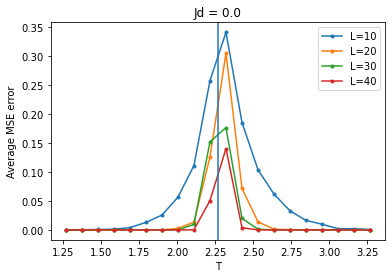

In [14]:
err_10 = [sum(errors[0][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_20 = [sum(errors[1][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_30 = [sum(errors[2][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_40 = [sum(errors[3][i*512:(i+1)*512])/512 for i in range(num_temps)]

plt.plot(T, err_10, marker='.', label='L=10')
plt.plot(T, err_20, marker='.', label='L=20')
plt.plot(T, err_30, marker='.', label='L=30')
plt.plot(T, err_40, marker='.', label='L=40')
plt.title('Jd = 0.0')
plt.xlabel('T')
plt.ylabel('Average MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

In [22]:
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))

num_temps = 20
Jd = -0.3
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 1.0, T_c + 1.0, num_temps)

L = [10, 20, 30, 40]

num_conf_tr = 2048
num_conf_ts = 512
outputs = []
errors = []

criterion = nn.BCEWithLogitsLoss()     

for i in range(len(L)):
    l = L[i]
    model = Net()
    PATH = f'models/{L[i]}_0.0.pt'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    test_dataloader = load_data(Jd, l, num_conf_ts, T, num_temps, batch_size=1, shuffle_opt=False, opt='test')
    outp_i, errors_i = testing(model, test_dataloader, criterion, batch_size=1)
    outputs.append(outp_i)
    errors.append(errors_i)
    

Accuracy = 0.9053505659103394
Accuracy = 0.9546893835067749
Accuracy = 0.9765241742134094
Accuracy = 0.9846561551094055


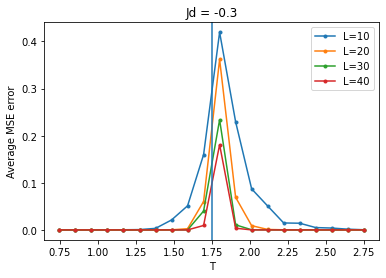

In [23]:
err_10 = [sum(errors[0][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_20 = [sum(errors[1][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_30 = [sum(errors[2][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_40 = [sum(errors[3][i*512:(i+1)*512])/512 for i in range(num_temps)]

plt.plot(T, err_10, marker='.', label='L=10')
plt.plot(T, err_20, marker='.', label='L=20')
plt.plot(T, err_30, marker='.', label='L=30')
plt.plot(T, err_40, marker='.', label='L=40')
plt.title('Jd = -0.3')
plt.xlabel('T')
plt.ylabel('Average MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

In [24]:
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))

num_temps = 20
Jd = -0.5
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 1.0, T_c + 1.0, num_temps)

L = [10, 20, 30, 40]

num_conf_tr = 2048
num_conf_ts = 512
outputs = []
errors = []

criterion = nn.BCEWithLogitsLoss()     

for i in range(len(L)):
    l = L[i]
    model = Net()
    PATH = f'models/{L[i]}_0.0.pt'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    test_dataloader = load_data(Jd, l, num_conf_ts, T, num_temps, batch_size=1, shuffle_opt=False, opt='test')
    outp_i, errors_i = testing(model, test_dataloader, criterion, batch_size=1)
    outputs.append(outp_i)
    errors.append(errors_i)
    

Accuracy = 0.9099100828170776
Accuracy = 0.9550744891166687
Accuracy = 0.9748064279556274
Accuracy = 0.9811307191848755


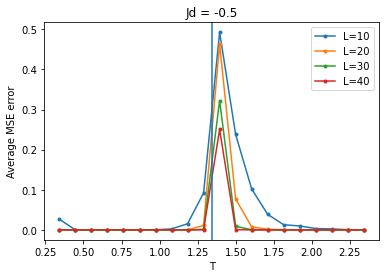

In [25]:
err_10 = [sum(errors[0][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_20 = [sum(errors[1][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_30 = [sum(errors[2][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_40 = [sum(errors[3][i*512:(i+1)*512])/512 for i in range(num_temps)]

plt.plot(T, err_10, marker='.', label='L=10')
plt.plot(T, err_20, marker='.', label='L=20')
plt.plot(T, err_30, marker='.', label='L=30')
plt.plot(T, err_40, marker='.', label='L=40')
plt.title('Jd = -0.5')
plt.xlabel('T')
plt.ylabel('Average MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

In [33]:
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))

num_temps = 100
Jd = 0.0
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

L = [10, 20, 30]

num_conf_tr = 2048
num_conf_ts = 512
outputs = []
errors = []

criterion = nn.BCEWithLogitsLoss()     

for i in range(len(L)):
    l = L[i]
    model = Net()
    PATH = f'models/{L[i]}_0.0.pt'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    test_dataloader = load_data(Jd, l, num_conf_ts, T, num_temps, batch_size=1, shuffle_opt=False, opt='test')
    outp_i, errors_i = testing(model, test_dataloader, criterion, batch_size=1)
    outputs.append(outp_i)
    errors.append(errors_i)
    

Accuracy = 0.7034539580345154
Accuracy = 0.8272941708564758
Accuracy = 0.8876217007637024


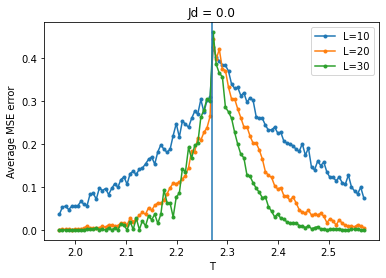

In [34]:
err_10 = [sum(errors[0][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_20 = [sum(errors[1][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_30 = [sum(errors[2][i*512:(i+1)*512])/512 for i in range(num_temps)]

plt.plot(T, err_10, marker='.', label='L=10')
plt.plot(T, err_20, marker='.', label='L=20')
plt.plot(T, err_30, marker='.', label='L=30')
plt.title('Jd = 0.0')
plt.xlabel('T')
plt.ylabel('Average MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

In [28]:
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))

num_temps = 100
Jd = -0.3
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

L = [10, 20, 30]

num_conf_tr = 2048
num_conf_ts = 512
outputs = []
errors = []

criterion = nn.BCEWithLogitsLoss()     

for i in range(len(L)):
    l = L[i]
    model = Net()
    PATH = f'models/{L[i]}_0.0.pt'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    test_dataloader = load_data(Jd, l, num_conf_ts, T, num_temps, batch_size=1, shuffle_opt=False, opt='test')
    outp_i, errors_i = testing(model, test_dataloader, criterion, batch_size=1)
    outputs.append(outp_i)
    errors.append(errors_i)
    

Accuracy = 0.7392210364341736
Accuracy = 0.8485775589942932
Accuracy = 0.9002339243888855


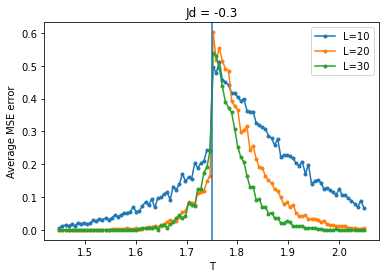

In [30]:
err_10 = [sum(errors[0][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_20 = [sum(errors[1][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_30 = [sum(errors[2][i*512:(i+1)*512])/512 for i in range(num_temps)]

plt.plot(T, err_10, marker='.', label='L=10')
plt.plot(T, err_20, marker='.', label='L=20')
plt.plot(T, err_30, marker='.', label='L=30')
plt.title('Jd = -0.3')
plt.xlabel('T')
plt.ylabel('Average MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

In [31]:
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))

num_temps = 100
Jd = -0.5
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

L = [10, 20, 30]

num_conf_tr = 2048
num_conf_ts = 512
outputs = []
errors = []

criterion = nn.BCEWithLogitsLoss()     

for i in range(len(L)):
    l = L[i]
    model = Net()
    PATH = f'models/{L[i]}_0.0.pt'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    test_dataloader = load_data(Jd, l, num_conf_ts, T, num_temps, batch_size=1, shuffle_opt=False, opt='test')
    outp_i, errors_i = testing(model, test_dataloader, criterion, batch_size=1)
    outputs.append(outp_i)
    errors.append(errors_i)
    

Accuracy = 0.7606751918792725
Accuracy = 0.8499330878257751
Accuracy = 0.9018613696098328


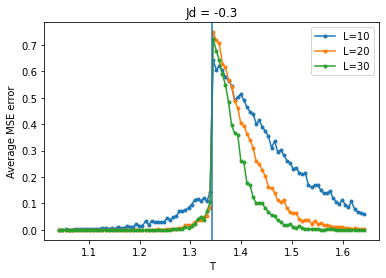

In [32]:
err_10 = [sum(errors[0][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_20 = [sum(errors[1][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_30 = [sum(errors[2][i*512:(i+1)*512])/512 for i in range(num_temps)]

plt.plot(T, err_10, marker='.', label='L=10')
plt.plot(T, err_20, marker='.', label='L=20')
plt.plot(T, err_30, marker='.', label='L=30')
plt.title('Jd = -0.5')
plt.xlabel('T')
plt.ylabel('Average MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()